Imports

In [384]:
import pandas as pd
import matplotlib.pyplot as plt
import misc

Reading in the Dataset
==

This notebook explores the features without modifying them.

It picks up from the "data_after_part1.csv" dataset saved in the "Data Quality - Part 1" notebook.

In [412]:
# I've chosen to keep the old index for now.
data = pd.read_csv("data_after_part1.csv", parse_dates = [1,2,3], index_col=0)

for field in data.columns[3:]:
    data[field] = data[field].astype("category")

data.head(3)

,cdc_case_earliest_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2020-08-25,2020-08-27,2020-08-25,Laboratory-confirmed case,Female,30 - 39 Years,Hispanic/Latino,No,Unknown,No,Unknown
1,2020-12-15,2020-12-15,NaT,Laboratory-confirmed case,Female,10 - 19 Years,"Black, Non-Hispanic",No,Unknown,No,No
2,2020-09-21,NaT,2020-09-21,Laboratory-confirmed case,Female,10 - 19 Years,Unknown,No,Missing,No,Missing


Summary Statistics
==

It can already be seen from the table that some of these data sets have a large amount of missing values - icu_yn and medcond_yn in particular. 

Also, some Yes/No fields have 4 or even 5 possible values, which is odd at first glance.

The next step is to look at each feature individually.

In [414]:
data.select_dtypes("category").describe().T

,count,unique,top,freq
current_status,9290,2,Laboratory-confirmed case,8602
sex,9290,4,Female,4774
age_group,9290,10,20 - 29 Years,1714
race_ethnicity_combined,9290,9,Unknown,3611
hosp_yn,9290,5,No,4941
icu_yn,9290,4,Missing,6939
death_yn,9290,2,No,8954
medcond_yn,9290,4,Missing,6822


Individual Features
==

A function for describing datetime features.<br> 
(It plots and saves a histogram, and displays null count/percentage)

In [385]:
def describe(key):
    
    check_savedir()
    
    plt.figure()
    data[key].hist(bins=20)
    
    misc.plt_save(key + "_hist")
    
    nulls = data[key].isna().sum()
    null_msg = str(nulls) + " Nulls"
    
    if nulls > 0:
        nulls_percent = 100 * (nulls / len(data))
        null_msg += ", " + str(nulls_percent) + "%"
    
    print(f"({null_msg})")
    

Earliest Datetime
==

(Key: cdc_case_earliest_dt)

This is the earliest date-time available for a record. It could be the datetime at which the CDC received the information, or a datetime on the information received if available.

There are no nulls here, and the distribution is much as one would expect given the available data on the government website of Covid cases.


(0 Nulls)


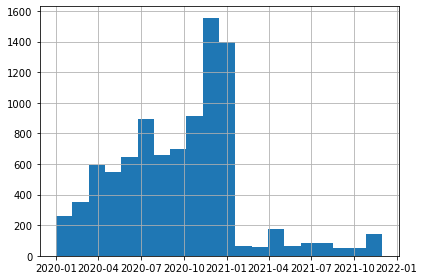

In [386]:
describe("cdc_case_earliest_dt")

Report Datetime
==

(Key: cdc_report_dt)

This field is **deprecated**. Given that the information page on the fields recommends that this no longer be used in favor of `cdc_case_earliest_dt`, this column is dropped in any case.

It does have an almost identical distribution to `cdc_case_earliest_dt`, so it makes sense that the other could replace it. It has a significant (but not overwhelming) proportion of nulls. 

On a trivial note, these nulls could be imputed to reasonable accuracy using the value `cdc_case_earliest_dt` and a scaling factor calculated from records without nulls, I think. But since this column is not being kept, I won't chase it down.

In [387]:
# describe("cdc_report_dt")

(6536 Nulls, 70.35522066738429%)


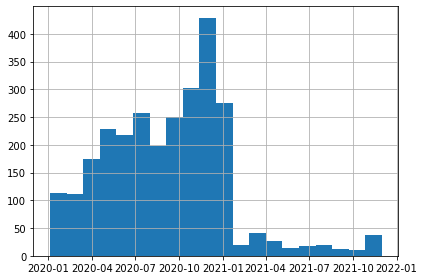

In [388]:
describe("pos_spec_dt")

Symptom Onset Date
==

(Key: onset_dt)

This has a lot of nulls. Less nulls than the positive test.

This could make a lot of sense. Only some of the incoming records began on this path after reporting symptoms, and of these, many might have something other going on than Covid.

(4449 Nulls, 47.890204520990316%)


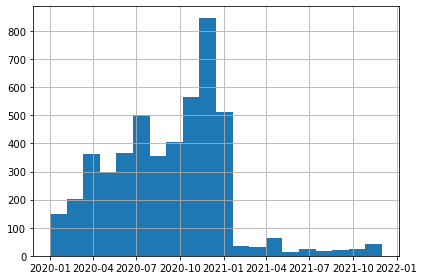

In [389]:
describe("onset_dt")

The following summary function will be used as a starting point for each categorical feature.

In [390]:
def describe(key, charts = None):
    """
    Display simple tallies and charts for a
    categorical feature.
    """
    
    result = pd.DataFrame(index = data[key].unique())
    
    result["Freq."] = data[key].value_counts()
    result["%"] = data[key].value_counts(normalize=True) * 100
    
    display(result)

    nulls = data[key].isna().sum()
    print("(Nulls:", nulls, end=")\n")
    
    if charts is None:
        charts = ["pie", "bar"]
    
    tally = data[key].value_counts()
    
    # Plot each chart, and save as a png to the
    # save directory.
    
    check_savedir()
    
    for chart in charts:
        
        # Each chart should be on a separate figure.
        plt.figure(figsize=[5, 5])
        
        # The ylabel gets in the way sometimes, and isn't
        # needed since only one plot is done at a time below.
        tally.plot(kind=chart, ylabel="")
        
        # Same again, but in picture form and on a larger
        # figure. The larger figure helps with labels.
        plt.figure(figsize=[10, 10])
        tally.plot(kind=chart, ylabel="")
        path = savedir + "/" + key + "_" + chart + ".png"
        plt.savefig(path)
        plt.close()

Current Status
==

(Key "current_satus")

Two unique values here. No nulls!!! This is about as perfect as things get on that front.

Taking a look at the relative frequencies, we can see that the Laboratory-confirmed cases dominate. Caution might be needed there in future.

,Freq.,%
Laboratory-confirmed case,8602,92.594187
Probable Case,688,7.405813


(Nulls: 0)


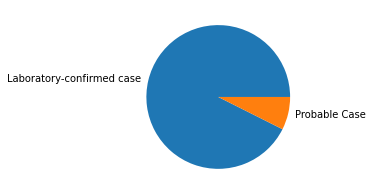

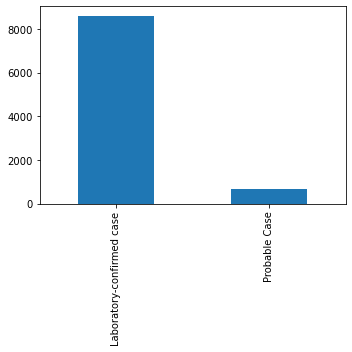

In [391]:
describe("current_status")

Sex
==

(Key: "sex")

Four values. Female and Male are the expected, directly useful ones.

Missing and Unknown are interesting. In theory they could provide different information, since one is probably given by the user and the other inferred automatically. However, in terms of providing information about gender, it is largely useless.

More info about that in the Data Action Plan, though.

,Freq.,%
Female,4774,51.388590
Male,4426,47.642626
Unknown,75,0.807320
Missing,15,0.161464


(Nulls: 0)


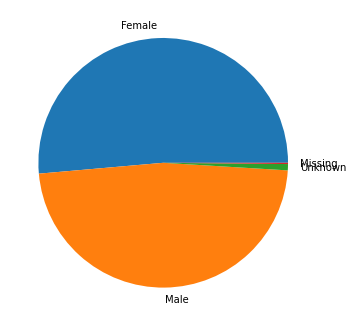

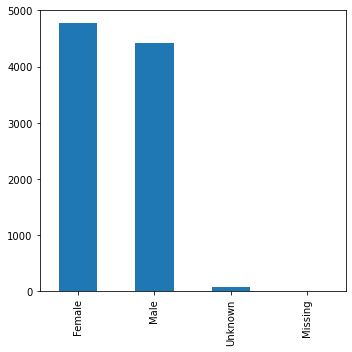

In [392]:
describe("sex")

Age Group
==

(Key: "age_group")

Simple age ranges, spread out as one might expect. It might be worth making a numerical feature from this.

I'm not sure what to make of the distribution right now, but it seems to make sense when you consider the distribution of age in general Ireland and account for the fact that children are remarkably resistent to the virus and less of a concern when testing. Maybe.

There are, again, a tiny number of rows with missing age. Dropping them and missing gender rows, we're still at about a percent only.

,Freq.,%
30 - 39 Years,1439,15.489774
10 - 19 Years,998,10.742734
20 - 29 Years,1714,18.449946
60 - 69 Years,965,10.387513
40 - 49 Years,1356,14.596340
80+ Years,469,5.048439
50 - 59 Years,1315,14.155005
70 - 79 Years,593,6.383208
0 - 9 Years,429,4.617869
Missing,12,0.129171


(Nulls: 0)


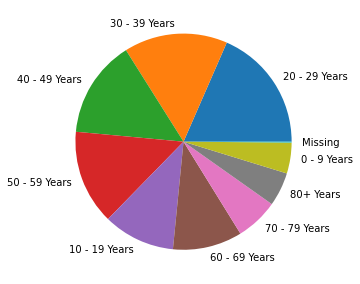

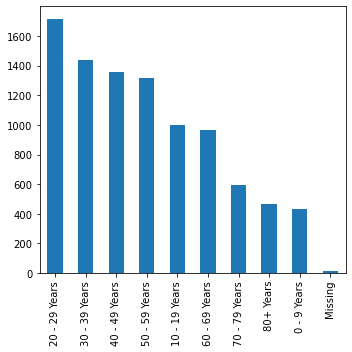

In [393]:
describe("age_group", charts = ["pie", "bar"])

Race and Ethnicity
==

(Key: race_ethnicity_combined)

This is a mess.

For one, it would be worth trying to disentangle the features into two: one with Black/Asian/White/etc, and another with this Hispanic thing I'm not quite sure what to make of.

For another, there is a huge chunk of "Unknown" items here, and a tiny portion of "Missing". There is a "Multiple/Other" section, I imagine this has more to do with users not putting down their race than a missing category. It's a large enough proportion of rows that dropping them would be a significant loss of data.

,Freq.,%
Hispanic/Latino,980,10.548977
"Black, Non-Hispanic",671,7.222820
Unknown,3611,38.869752
"Asian, Non-Hispanic",252,2.712594
"White, Non-Hispanic",3146,33.864370
"Multiple/Other, Non-Hispanic",470,5.059203
"American Indian/Alaska Native, Non-Hispanic",57,0.613563
Missing,85,0.914962
"Native Hawaiian/Other Pacific Islander, Non-Hispanic",18,0.193757


(Nulls: 0)


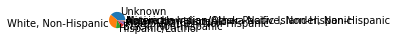

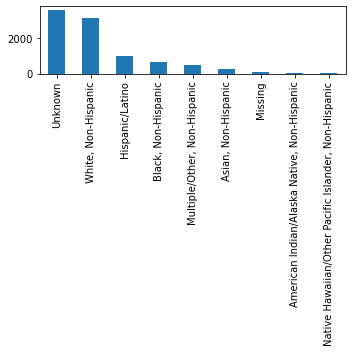

In [394]:
describe("race_ethnicity_combined")

Hospitalized
==

(Key: hosp_yn)

Lots of "Missing" and "Unknown" with this one, same discussion as for "sex" applies.

There is also a small fraction of "OTH" items, which seem to indicate "Other".

Otherwise it's just a straightforward yes/no answer. "No" dominates, with a higher count than all other values put together.

,Freq.,%
No,4941,53.186222
Missing,2101,22.615716
Yes,673,7.244349
Unknown,1572,16.921421
OTH,3,0.032293


(Nulls: 0)


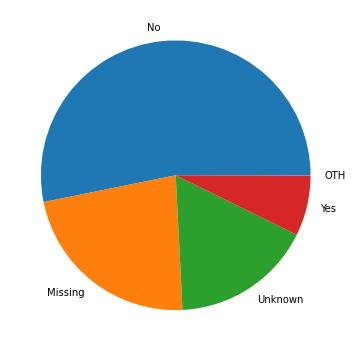

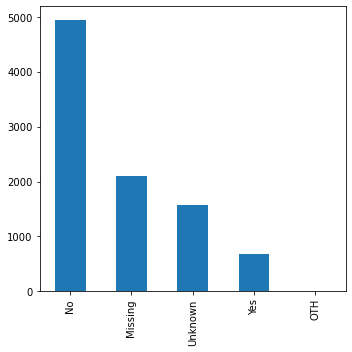

In [395]:
describe("hosp_yn")

Intensive Care
==

(Key: icu_yn)

A huge proportion of "Missing" values with this one!

It might be worth imputing "No" for "Unknown" here, since it is expected that few records would have "Yes" for this field. A domain expert would be useful to help here, as would iteration - trying a model with and without imputing.

Otherwise, simply leaving Missing be might well achieve the same result at the machine learning stage - the model that is extracted might well pick up similar rules or weights (or whatever parameterizes the model) for "Missing" and "No".

,Freq.,%
Unknown,1258,13.541442
Missing,6939,74.693219
No,1017,10.947255
Yes,76,0.818084


(Nulls: 0)


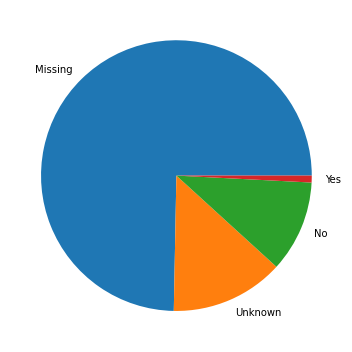

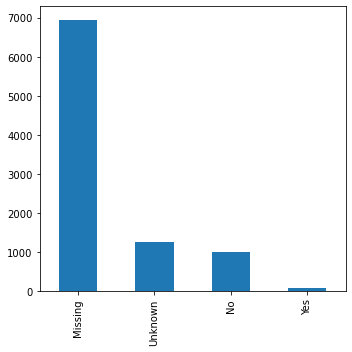

In [396]:
describe("icu_yn")

Death
==

(Key: death_yn)

This is the **target feature**.

There are no missing values here, just "Yes" and "No". That's good, because given that it is the target, it being missing from a row would likely mean use having to drop the row.

It is heavily dominated by the "No" value, which is expected. This presents a challenge w.r.t random sampling later on in the Data Analysis process, but that is not our concern right now.

,Freq.,%
No,8954,96.383208
Yes,336,3.616792


(Nulls: 0)


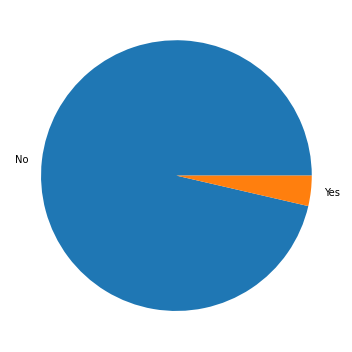

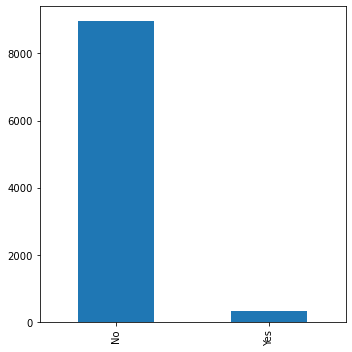

In [397]:
describe("death_yn")

Medical Condition
==

(Key: medcond_yn)

Similar to ICU here. Lots of "Missing", but "Missing" and "Unknown" can most likely be imputed as "No", since it is expected that most people would not have a (relevant) medical condition, and, moreover, most people that do would know about it while most people that don't would have had no method or reason to confirm this.

It would worth confirming this hunch with a domain expert, though.

,Freq.,%
Unknown,741,7.976319
No,906,9.752422
Missing,6822,73.433800
Yes,821,8.837460


(Nulls: 0)


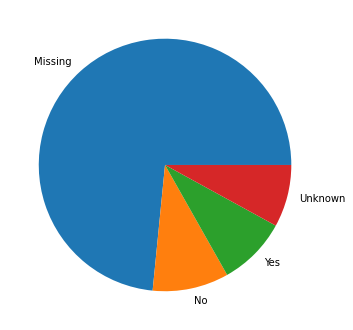

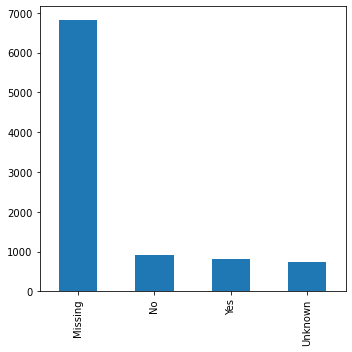

In [398]:
describe("medcond_yn")